# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

8
__header__
<class 'bytes'>
__version__
<class 'str'>
__globals__
<class 'list'>
I_noisy4
<class 'numpy.ndarray'>
I_noisy1
<class 'numpy.ndarray'>
I_noisy2
<class 'numpy.ndarray'>
I_noisy3
<class 'numpy.ndarray'>
I_noisefree
<class 'numpy.ndarray'>


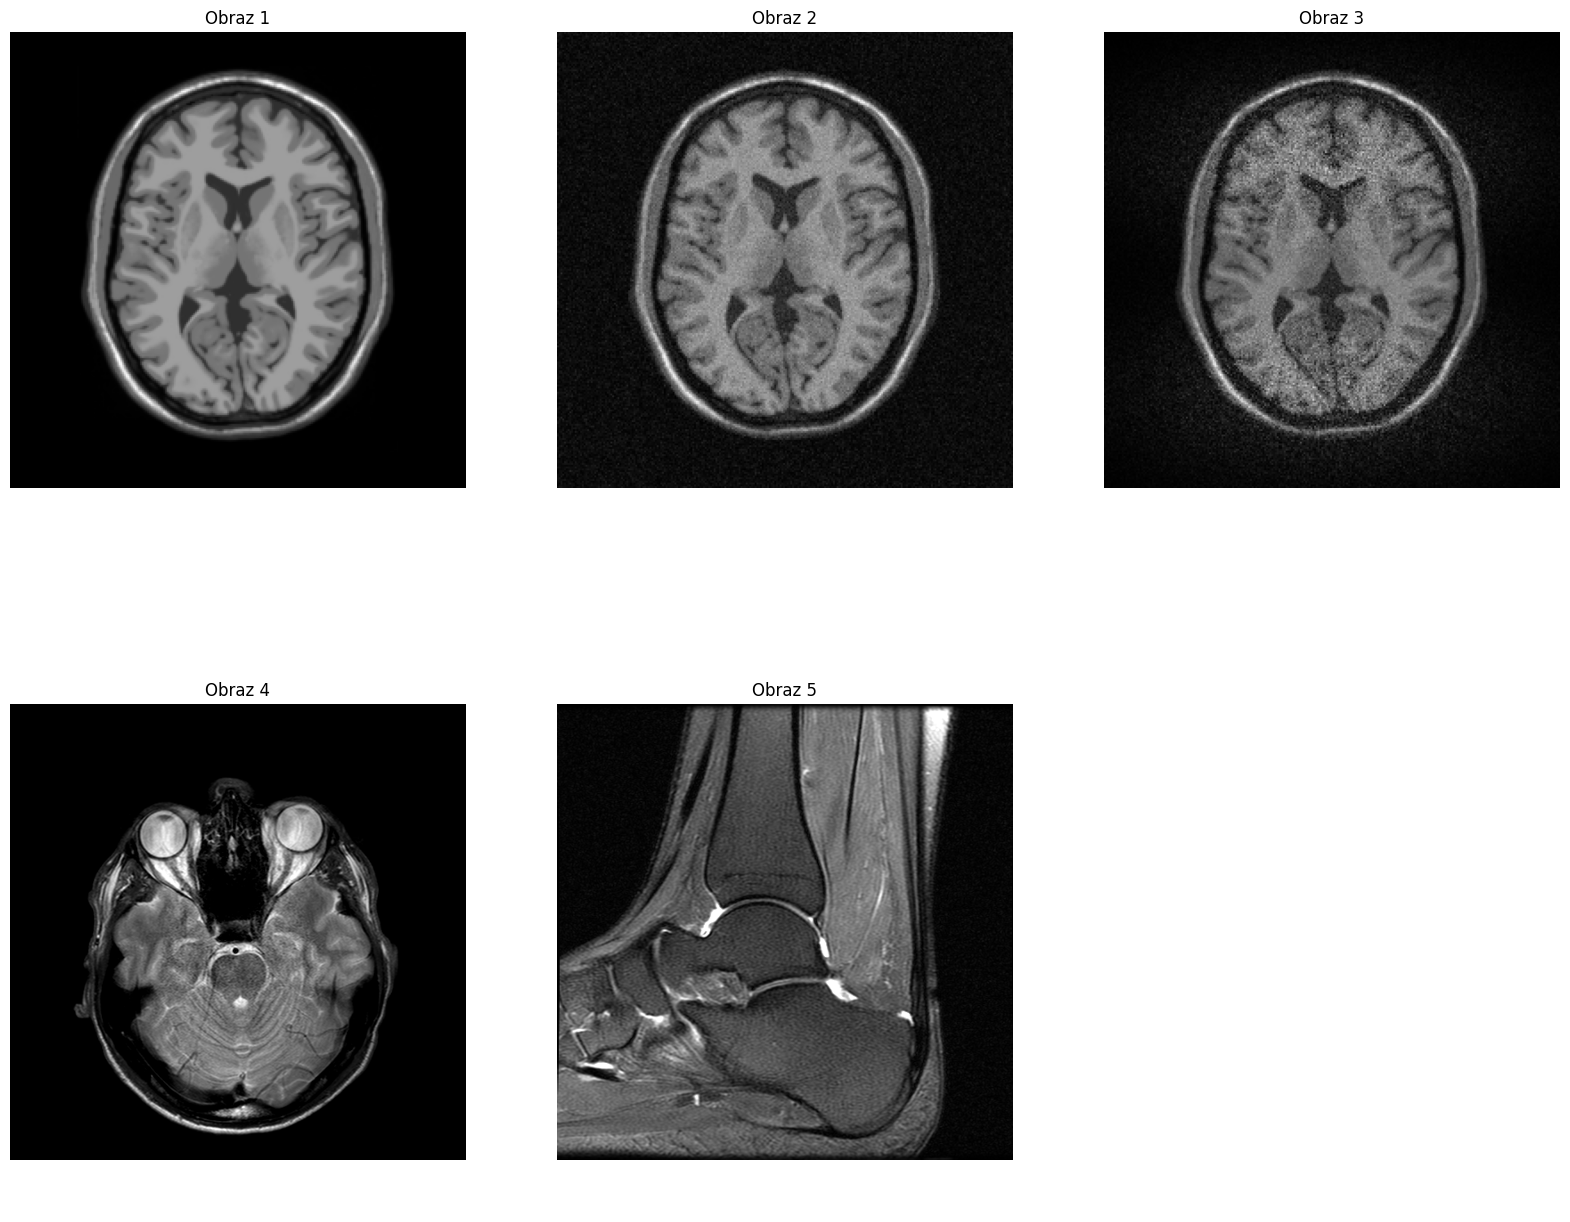

In [8]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import math

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/'

fileNames = ["MR_data.mat"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

def plots(**kwargs):

    n = len(kwargs)
    fig, axes = plt.subplots(((n - 1) // 3) + 1, np.min([3, n]))
    fig.set_size_inches(np.min([n * 6, 20]), (((n - 1) // 3) + 1) * 8)
    i = 0

    for key, image in kwargs.items():
        if n == 1:
            axes.imshow(image, "gray")
            axes.axis("off")
            axes.set_title(key)
            axes.set_facecolor('white')
        elif n <= 3:
            axes[i].imshow(image, "gray")
            axes[i].axis("off")
            axes[i].set_title(key)
            axes[i].set_facecolor('white')
        elif n > 3:
            axes[i // 3, i % 3].imshow(image, "gray")
            axes[i // 3, i % 3].set_title(key)
            axes[i // 3, i % 3].set_facecolor('white')

        i += 1

    if n > 1:
        for ax in axes.flat:
            ax.axis("off")

    fig.patch.set_facecolor('white')

    plt.show()

mat = loadmat("MR_data.mat")
print(len(mat))

input_1 = mat["I_noisefree"]
input_2 = mat["I_noisy1"]
input_3 = mat["I_noisy2"]
input_4 = mat["I_noisy3"]
input_5 = mat["I_noisy4"]

mat_images = [
    input_1,
    input_2,
    input_3,
    input_4,
    input_5
]

images = {}

for i, element in enumerate(mat_images):
    images[f"Obraz {i + 1}"] = element

# for key in mat.keys():
#     print(key)
#     print(type(mat[key]))

plots(**images)

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

In [ ]:
# Copied from lab_6
# odchyenie standardowe rowne rozmiarowi, mniej wiecej 3 - 5, Pan ustawia zazwyczaj 5x5 i zaczyna od 3 odchylenia
# dobra wartsc w drugim zadaniu to tak do 15 jesli chodzi o roznice w odległościach w przeciwdzedzinie (chodzi chyba o roznice wartosci pikseli 0 - 255)

def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g /g.sum()


def mesh(fun, size):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    X = np.arange(-size//2, size//2, 1)
    Y = np.arange(-size//2, size//2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun

    ax.plot_surface(X, Y, Z)

    plt.show()

def classic_convolution(img: np.ndarray, ksize):
    if not ksize % 2:
        height, width = img.shape
        border = (ksize // 2)

        IConv = np.copy(img)

        for i in range(border, height - border):
            for j in range(border, width - border):


    return None

window_size = 3
delta = 0



### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.